In [1]:
!pip install -q transformers datasets accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.6 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency 

In [13]:
import pandas as pd
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [14]:
# Load and Prepare Dataset
df = pd.read_csv("/kaggle/input/processed-tickets/processed_tickets.csv")

# Encode target labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['queue'])

# Select required columns
df = df[['full_text', 'label']]

# Split into train and test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['full_text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

In [17]:
# Custom Dataset Class
class TicketDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=512)
        self.labels = labels.tolist()
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [18]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [21]:
# Training and Evaluation Function
def train_and_evaluate(model_name, train_texts, val_texts, train_labels, val_labels, num_labels):
    print(f"\n--- Training {model_name} ---")
    
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Add padding token if it doesn't exist (especially for RoBERTa)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    
    # Dataset
    train_dataset = TicketDataset(train_texts, train_labels, tokenizer)
    val_dataset = TicketDataset(val_texts, val_labels, tokenizer)
    
    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced', 
        classes=np.unique(train_labels), 
        y=train_labels
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float)
    
    # Move to same device as model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    class_weights = class_weights.to(device)
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./results/{model_name.replace('/', '_')}",  # Handle model names with slashes
        per_device_train_batch_size=32,  # Reduced batch size for memory efficiency
        per_device_eval_batch_size=32,
        num_train_epochs=3,
        eval_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="no",
        load_best_model_at_end=False,
        report_to="none",
        dataloader_num_workers=0,  # Avoid multiprocessing issues
        remove_unused_columns=False
    )
    
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        class_weights=class_weights
    )
    
    # Train model
    start_train = time.time()
    trainer.train()
    end_train = time.time()
    training_time = end_train - start_train
    
    # Inference time on first 100 samples
    inference_texts = val_texts.iloc[:100] if hasattr(val_texts, 'iloc') else val_texts[:100]
    inference_labels = val_labels.iloc[:100] if hasattr(val_labels, 'iloc') else val_labels[:100]
    inference_dataset = TicketDataset(inference_texts, inference_labels, tokenizer)
    inference_loader = DataLoader(inference_dataset, batch_size=16)
    
    model.eval()
    preds = []
    start_inf = time.time()
    with torch.no_grad():
        for batch in inference_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**inputs)
            preds.append(torch.argmax(outputs.logits, dim=1).cpu().numpy())
    end_inf = time.time()
    inference_time = end_inf - start_inf
    
    # Accuracy on full validation set
    val_loader = DataLoader(val_dataset, batch_size=16)
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels']
            outputs = model(**inputs)
            all_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            all_labels.extend(labels.numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    
    # Clean up memory
    del model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    return {
        'model': model_name,
        'training_time': training_time,
        'inference_time': inference_time,
        'accuracy': accuracy
    }


In [22]:
# Run All Models
model_names = [
    "bert-base-uncased",
    "distilbert-base-uncased",
    "roberta-base"
]

results = []
for model_name in model_names:
    try:
        result = train_and_evaluate(
            model_name, train_texts, val_texts, train_labels, val_labels, 
            num_labels=len(label_encoder.classes_)
        )
        results.append(result)
        print(f"Completed {model_name}")
    except Exception as e:
        print(f"Error with {model_name}: {str(e)}")
        continue

results_df = pd.DataFrame(results)
print("\nResults Summary:")
print(results_df)


--- Training bert-base-uncased ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/558466582.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,1.357500,1.289090
2,1.205900,1.178682
3,1.006000,1.184293


Completed bert-base-uncased

--- Training distilbert-base-uncased ---


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/558466582.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,1.331000,1.246816
2,1.160100,1.193116
3,0.973400,1.195077


Completed distilbert-base-uncased

--- Training roberta-base ---


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/558466582.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,1.374600,1.346703
2,1.272000,1.318745
3,1.212100,1.229910


Completed roberta-base

Results Summary:
                     model  training_time  inference_time  accuracy
0        bert-base-uncased    1589.122217        0.617213  0.489308
1  distilbert-base-uncased     800.140627        0.313340  0.486373
2             roberta-base    1448.292718        0.587389  0.464990


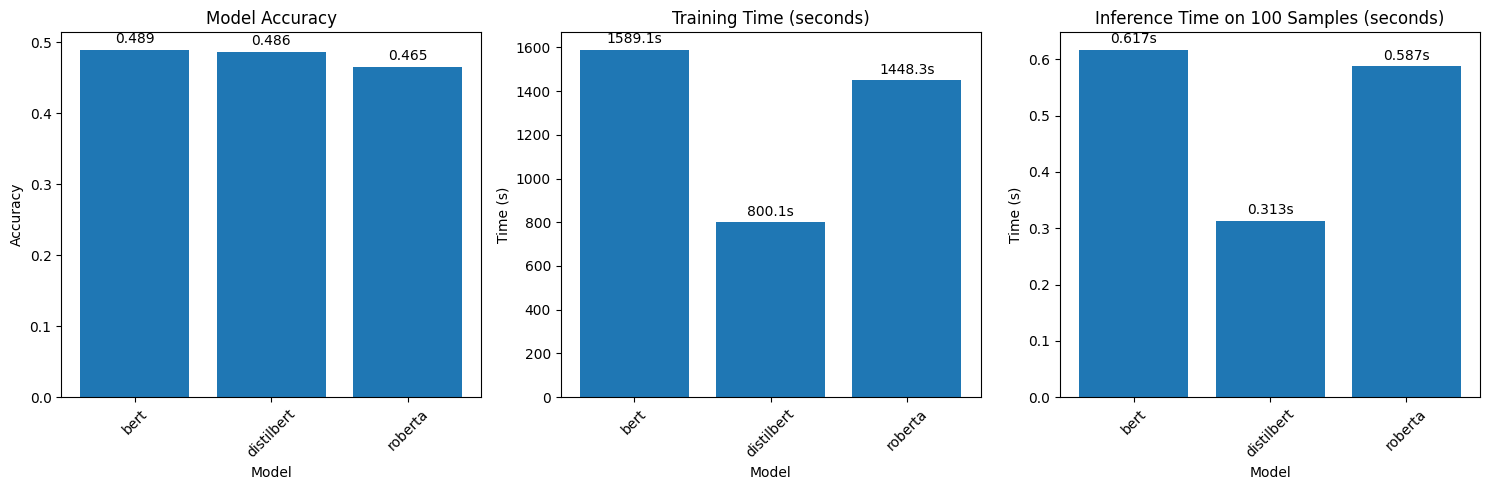

In [23]:
# Visualization
if len(results) > 0:
    plt.figure(figsize=(15, 5))
    
    # Accuracy Bar Plot
    plt.subplot(1, 3, 1)
    bars1 = plt.bar(range(len(results_df)), results_df['accuracy'])
    plt.title("Model Accuracy")
    plt.xlabel("Model")
    plt.ylabel("Accuracy")
    plt.xticks(range(len(results_df)), [name.split('-')[0] for name in results_df['model']], rotation=45)
    
    # Add value labels on bars
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom')
    
    # Training Time Plot
    plt.subplot(1, 3, 2)
    bars2 = plt.bar(range(len(results_df)), results_df['training_time'])
    plt.title("Training Time (seconds)")
    plt.xlabel("Model")
    plt.ylabel("Time (s)")
    plt.xticks(range(len(results_df)), [name.split('-')[0] for name in results_df['model']], rotation=45)
    
    # Add value labels on bars
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(results_df['training_time'])*0.01,
                f'{height:.1f}s', ha='center', va='bottom')
    
    # Inference Time Plot
    plt.subplot(1, 3, 3)
    bars3 = plt.bar(range(len(results_df)), results_df['inference_time'])
    plt.title("Inference Time on 100 Samples (seconds)")
    plt.xlabel("Model")
    plt.ylabel("Time (s)")
    plt.xticks(range(len(results_df)), [name.split('-')[0] for name in results_df['model']], rotation=45)
    
    # Add value labels on bars
    for i, bar in enumerate(bars3):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(results_df['inference_time'])*0.01,
                f'{height:.3f}s', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
else:
    print("No results to visualize - all models failed to train.")